In [307]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../..")

from neuroprob import utils, point_process
from neuroprob.utils import neural

### Linear precession with DRZ

We start by assuming a circular place field. Define the following:
\begin{align}
\mathbf{x} &- \text{position of animal} \\
d &- \text{animal's heading relative to place field peak direction $0-2\pi$} \\
\mathbf{x}_0 &- \text{centre of place field and location of peak firing rate} \\
\Sigma &- \text{covariance matrix of circular place field} \\
r_{max} &- \text{peak firing rate} \\
f_{\theta} &- \text{frequency of Local Field Potential (LFP)} \\
H(x) &- \text{Heaviside-style step function from -1 to +1 at $x=0$} \\
\end{align}

The rate equation can then be written as:
\begin{equation}
    r = r_x(\mathbf{x}) \cdot r_{\text{DRZ}}(\text{DRZ}, d)
\end{equation}

where
\begin{align}
r_x(\mathbf{x}) &= r_0 \exp\Big( -(\mathbf{x} - \mathbf{x}_0)^T \Sigma^{-1} (\mathbf{x} - \mathbf{x}_0)  \Big) \\
r_{\text{DRZ}}\big(\text{DRZ}(\mathbf{x}, d), \theta(t)\big) &= \exp \big(k \cos (\pi\text{DRZ} - \theta(t)\big) \\
\end{align}

and
\begin{align}
\text{DRZ}(\mathbf{x}, d) &= H(\cos(d))\Big(1 - \frac{r_x(\mathbf{x})}{r_{max}}\Big) \\
\theta(t) &= 2\pi f_{\theta}t \\
\end{align}

In [292]:
def gen_field_gaussian(x, x_0, sigma, r_0=1):
    """Creates a 2D Gaussian with centre x_0 and variances sigma (independent)."""
    r_x = r_0 * np.exp(-np.sum(((x-x_0) * 1/sigma)**2, axis=1))
    return r_x

def gen_field_DRZ(x, d, theta, x_0, sigma, r_0=1, k=1):
    # assumes rho = 0 (independent) bivariate gaussian
    # angles 0-2pi
    
    # 2D Gaussian Place Field
    r_x = gen_field_gaussian(x, x_0, sigma, r_0)

    DRZ = np.sign(-np.cos(d)) * (1 - r_x / r_0)
#     pdcd = np.cos(d) * (1 - r_x / r_0)
    
    r_DRZ = np.exp(k * np.cos(-np.pi * DRZ - theta))
    
    return r_x * r_DRZ, r_DRZ, DRZ

In [293]:
def base_angle(v0, v1, u0, u1):
    v = np.array([v0, v1])
    u = np.array([u0, u1])
    angle = np.arctan2(np.linalg.det([v, u]),np.dot(v, u))
    return angle
angle = np.vectorize(base_angle)

In [315]:
# Define place field
x_0 = np.array([0, 0])
sigma = 1
k = 1
r_0 = 5

# Define trajectory
n = 100
x = np.linspace(-2, 2, n+1)
y = np.linspace(0, 0, n+1)
coords = np.stack((x,y), axis=1)

peak_vector = x_0 - coords
peak_vector = peak_vector[:-1]
dir_vector = np.diff(coords, axis=0)
d = angle(peak_vector[:,0], peak_vector[:,1], dir_vector[:,0], dir_vector[:,1])

dt = 0.1
theta = np.linspace(np.pi, 7*2*np.pi, n) % (2*np.pi) - np.pi

x = x[:-1]
y = y[:-1]
coords = coords[:-1]

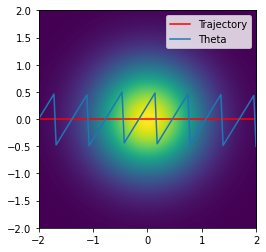

In [316]:
# Plot r_x and trajectory
x_grid = np.linspace(-2, 2, n)
y_grid = np.linspace(-2, 2, n)
coords_grid = np.array([(x, y) for x in x_grid for y in y_grid])
r_x = gen_field_gaussian(coords_grid, x_0, sigma, r_0)

plt.imshow(np.reshape(r_x, (n,n)), extent=(np.min(x_grid),
                                           np.max(x_grid),
                                           np.min(y_grid),
                                           np.max(y_grid)))
plt.plot(x, y, c='r', label='Trajectory')
plt.plot(x_grid, theta/(2*np.pi), label='Theta')
plt.xlim(np.min(x_grid), np.max(x_grid))
plt.ylim(np.min(y_grid), np.max(y_grid))
plt.legend()
plt.show()

In [317]:
rate, r_DRZ, DRZ = gen_field_DRZ(coords, d, theta, x_0, sigma, r_0, k)

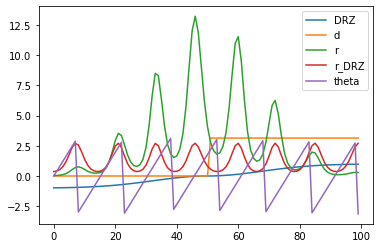

In [320]:
plt.plot(DRZ, label='DRZ')
plt.plot(d, label='d')
plt.plot(rate, label='r')
plt.plot(r_DRZ, label='r_DRZ')
plt.plot(theta, label='theta')
plt.legend()
plt.show()

In [321]:
t_spikes = []
# Store spikes, spike times for this neuron
spikes = point_process.gen_IPP(rate, dt, max_count=1e5)
for i, r in enumerate(rate):
    spike_times = neural.BinToTrain(spikes[i])
    t_spikes.append(spike_times) # get spike time indices

IndexError: invalid index to scalar variable.

In [322]:
t_spikes

[array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([0], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64)]

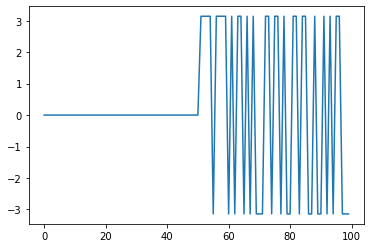

In [245]:
x = np.linspace(2, -2, n+1)
y = np.linspace(-2, 2, n+1)
coords = np.stack((x,y), axis=1)
peak_vector = x_0 - coords
peak_vector = peak_vector[:-1]
dir_vector = np.diff(coords, axis=0)
d = angle(peak_vector[:,0], peak_vector[:,1], dir_vector[:,0], dir_vector[:,1])
plt.plot(d)